# importing libraries



In [ ]:
!pip install pdf2image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from skimage.filters import threshold_local
from PIL import Image
import cv2
from pdf2image import convert_from_path

# PDF to JPEG coverter 

In [ ]:
#we will using pdf2image library for this purpose 
def pdf2image(path):
  pages = convert_from_path('pdf_file', 500)
  for page in pages:
    page.save('out.jpg', 'JPEG')

# Showing the taken image

In [ ]:
def showimage(path):
  img = Image.open(path)
  img.thumbnail((800,800), Image.ANTIALIAS)
  return img

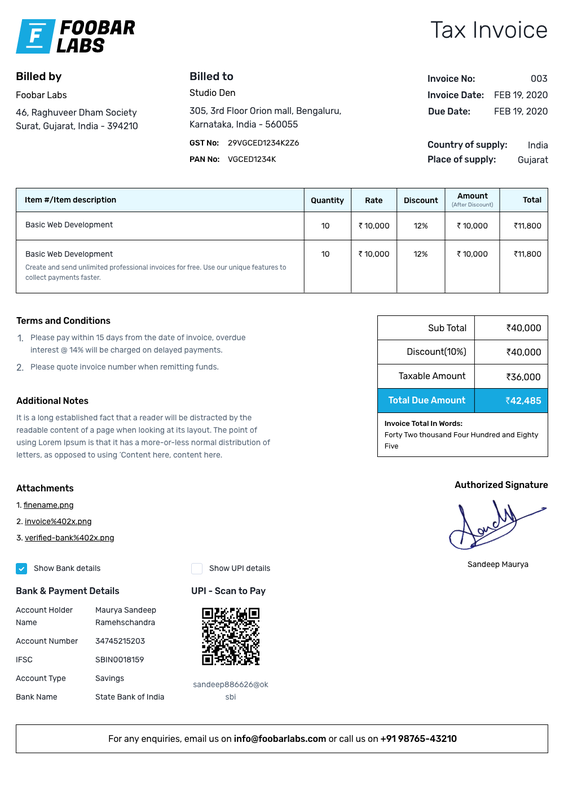

In [ ]:
showimage('/content/GST_Invoice_Template_1d797c2a14.png')

The taken image or pDF will not be uniform so we need to regsiter the image so we first we will proceed with countor detection in image 
There are few steps in it 
1. Grayscale conversion 
2. Gaussian filter for removing any noise present 
3. We will use the canny edge counter for countors detection

# Grayscale conversion

The sample image with extra boundaries is given below

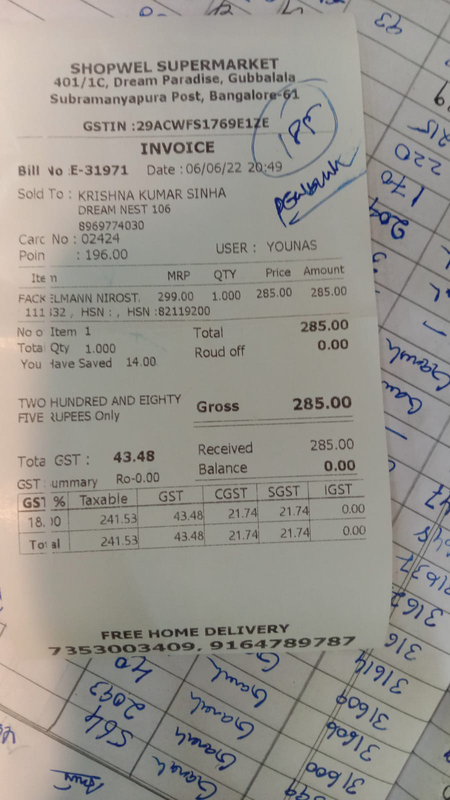

In [ ]:
showimage('/content/WhatsApp Image 2022-08-29 at 3.21.55 PM.jpeg')

The image will have more pixels so firstly we need to resize the image into smaller ratio pixels

In [ ]:
def opencv_resize(image, ratio):
  #defining height and width
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    #the final dimaensions
    dim = (width, height)
    #returning the resized iamge
    resized_image=cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized_image

In [ ]:
#shwoing the Colored image in RGb format
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
#showing the gray format image
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [ ]:
#reading the image using opencv 
image = cv2.imread('/content/WhatsApp Image 2022-08-29 at 9.45.57 PM (1).jpeg')
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

In [ ]:
#making the image grayscale 
def makegrayscale(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  plot_gray(gray)
  return gray

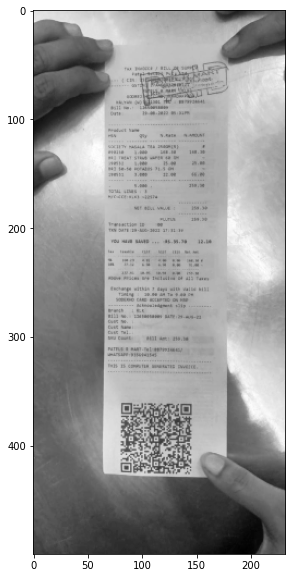

In [ ]:
gray=makegrayscale(image)

The above we have got the gray scaled image

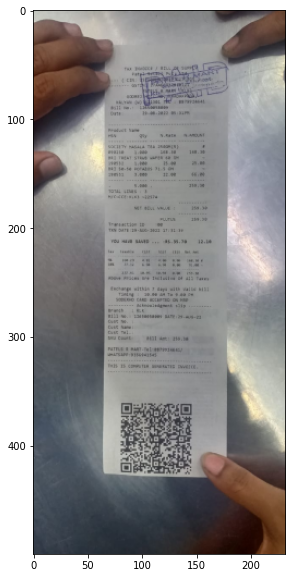

In [ ]:
plot_rgb(image)

# Guasian Filtering for denoising

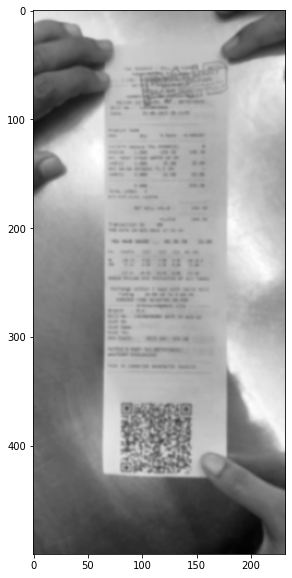

In [ ]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

# Detecting white corners in our image 

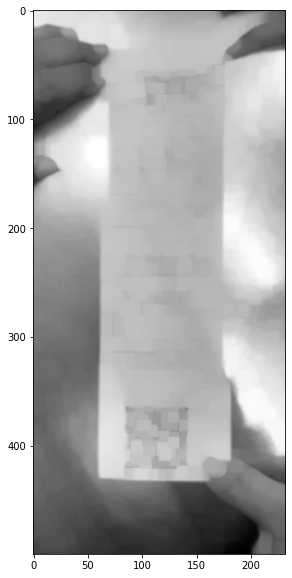

In [ ]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

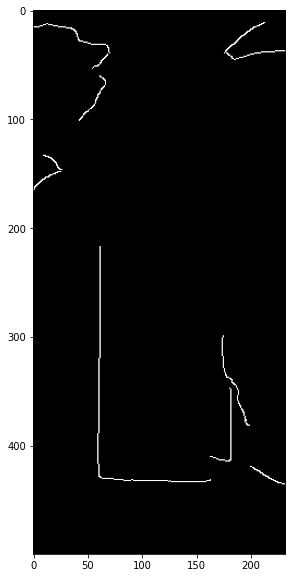

In [ ]:
#getting the canny edges 
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plot_gray(edged)

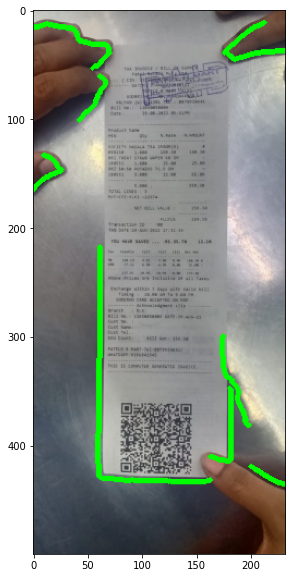

In [ ]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

# Making a combined function

In [ ]:
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [ ]:
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

In [ ]:
def countorusdetection(path):
  image = cv2.imread(path)
  # Downscale image as finding receipt contour is more efficient on a small image
  resize_ratio = 500 / image.shape[0]
  original = image.copy()
  image = opencv_resize(image, resize_ratio)
  gray=makegrayscale(image)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
  dilated = cv2.dilate(blurred, rectKernel)
  edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
  contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
  plot_rgb(image_with_contours)
  largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
  image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
  plot_rgb(image_with_largest_contours)
  receipt_contour = get_receipt_contour(largest_contours)
  image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
  plot_rgb(image_with_receipt_contour)

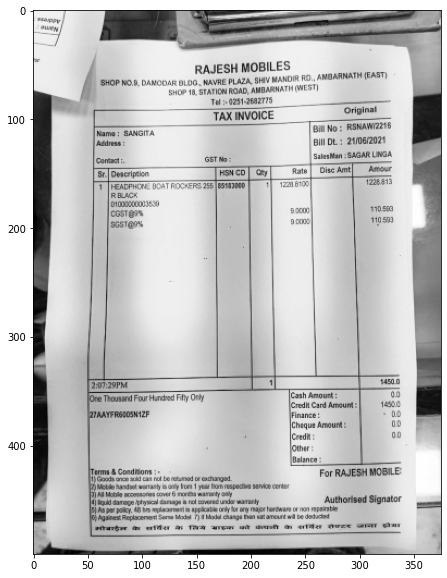

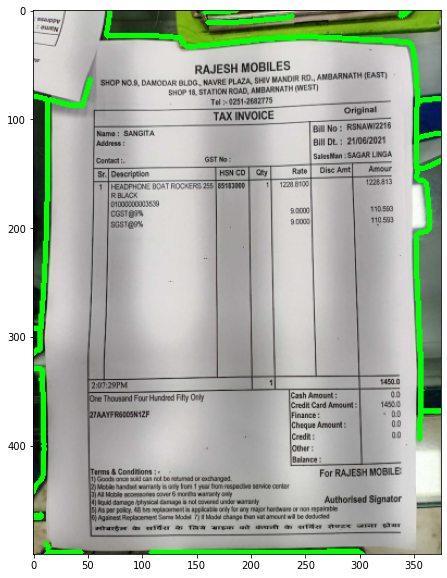

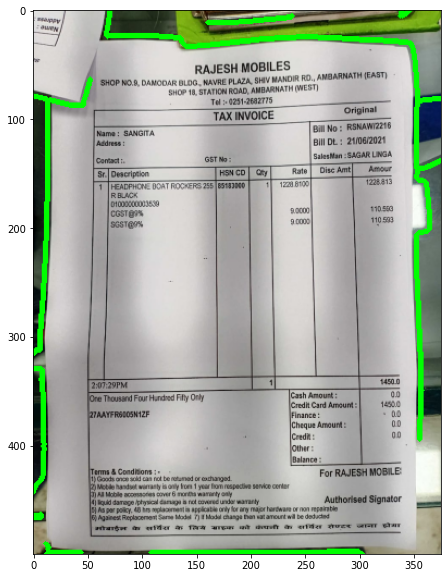

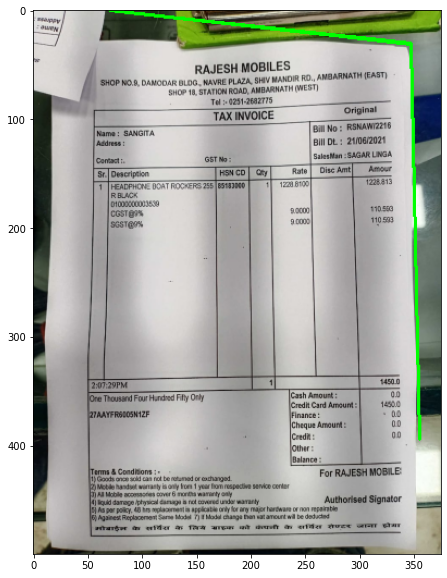

In [ ]:
countorusdetection('/content/WhatsApp Image 2022-08-29 at 9.45.57 PM.jpeg')

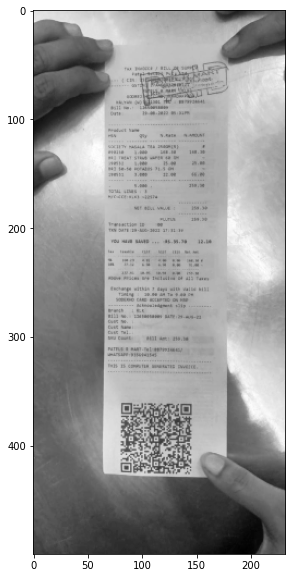

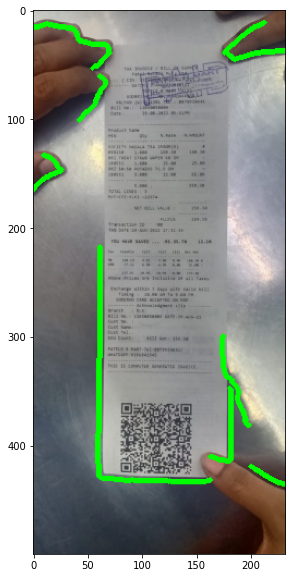

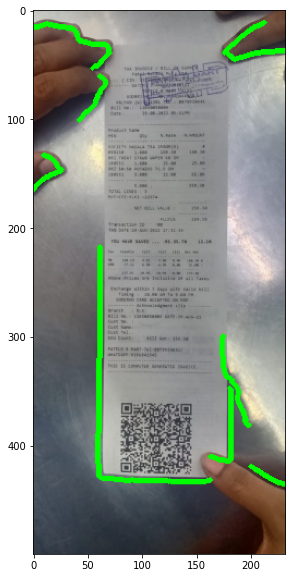

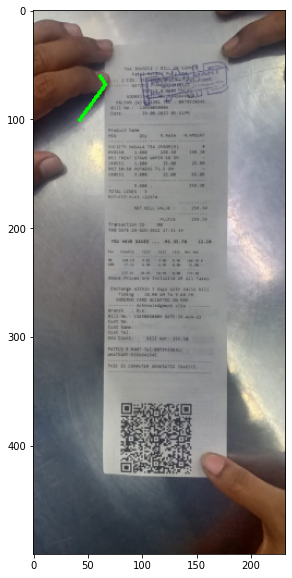

In [ ]:
countorusdetection('/content/WhatsApp Image 2022-08-29 at 9.45.57 PM (1).jpeg')

error: ignored

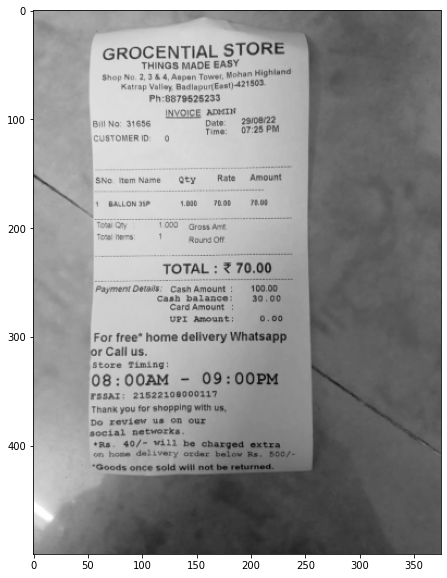

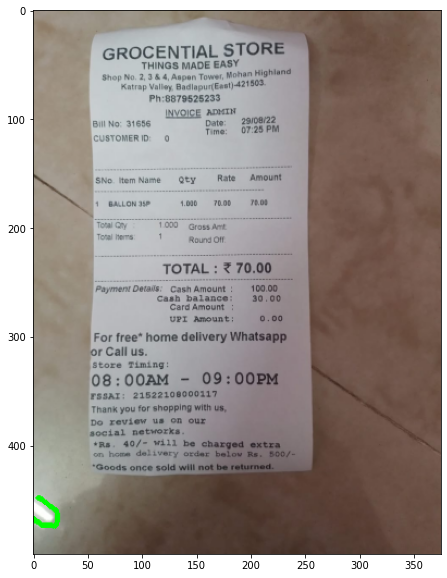

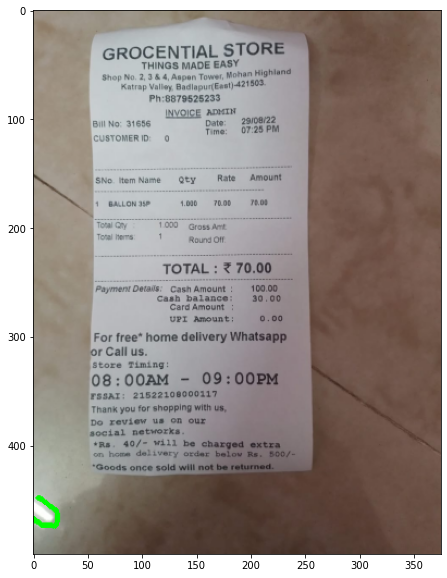

In [ ]:
countorusdetection('/content/WhatsApp Image 2022-08-29 at 9.45.58 PM.jpeg')

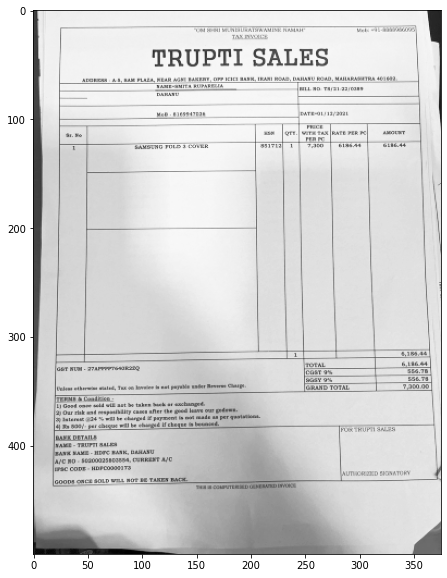

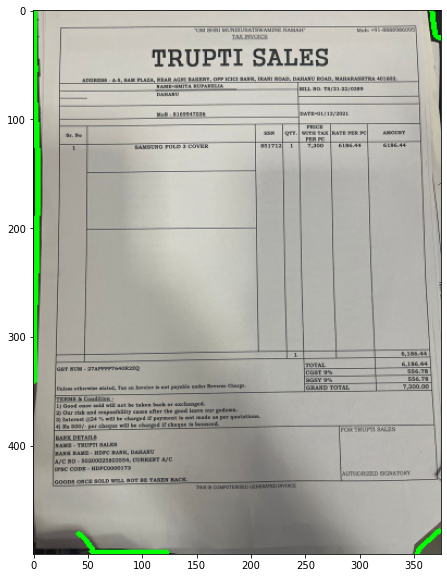

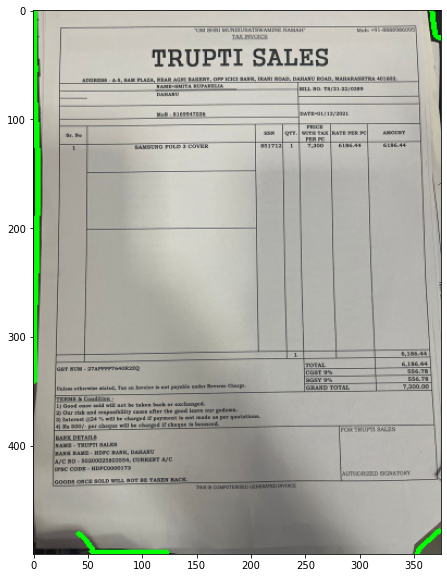

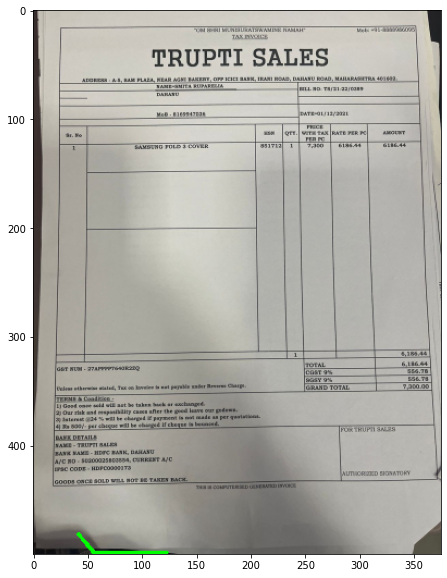

In [ ]:
countorusdetection('/content/WhatsApp Image 2022-08-29 at 9.49.10 PM.jpeg')

I have tried many images for receipt scanning but the countours are not wholly detection the countours so we have to drop this method

# Cropping and rotation of image

This function is used for countours to rectangle

In [ ]:
def contour_to_rect(contour):
  #reshaping countours to 4,2
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [ ]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))